# Jira Issue Resolution Time Prediction

In [ ]:
# ML Pipeline – Jira Issue Resolution Time Prediction
# 1. Load Jira dataset and inspect schema, data types, and target variable
# 2. Drop columns with more than 95% missing values
# 3. Convert date columns to datetime format
# 4. Create target variable (Resolution_Time) if not already present
# 5. Perform feature engineering:
#    - Time-based features (day, hour, weekend)
#    - Priority, issue type, and severity encoding
#    - Comment and activity-based features
#    - Text length features from summary and description
#    - Reporter workload features
# 6. Handle missing values in engineered and remaining features
# 7. Drop irrelevant, identifier, and leakage-prone columns
# 8. Perform Exploratory Data Analysis (EDA) on features vs resolution time
# 9. Split dataset into training and testing sets
# 10. Train baseline regression model(s)
# 11. Evaluate model performance using regression metrics
# 12. Perform feature selection and hyperparameter tuning
# 13. Evaluate Other model performance
# 14. Train final model and analyze feature importance

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load Jira dataset and inspect schema, data types, and target variable

In [ ]:
path = kagglehub.dataset_download("cesaranasco/jira-dataset")

print(os.listdir(path))

Using Colab cache for faster access to the 'jira-dataset' dataset.
['.nfs000000001b0786660000000f', 'GFG_FINAL.csv']


In [ ]:
df=pd.read_csv(os.path.join(path, "GFG_FINAL.csv"))
print('DataFrame Shape:', df.shape)
print('\nDataFrame Columns:', df.columns.tolist())
print('\nDataFrame Info:')
df.info()

DataFrame Shape: (49000, 491)

DataFrame Columns: ['Summary', 'Issue key', 'Issue id', 'Issue Type', 'Status', 'Project key', 'Project name', 'Project type', 'Project lead', 'Project description', 'Project url', 'Priority', 'Resolution', 'Assignee', 'Reporter', 'Creator', 'Created', 'Updated', 'Last Viewed', 'Resolved', 'Affects Version/s', 'Affects Version/s.1', 'Affects Version/s.2', 'Affects Version/s.3', 'Affects Version/s.4', 'Affects Version/s.5', 'Affects Version/s.6', 'Affects Version/s.7', 'Affects Version/s.8', 'Affects Version/s.9', 'Affects Version/s.10', 'Affects Version/s.11', 'Affects Version/s.12', 'Affects Version/s.13', 'Affects Version/s.14', 'Affects Version/s.15', 'Affects Version/s.16', 'Affects Version/s.17', 'Affects Version/s.18', 'Affects Version/s.19', 'Affects Version/s.20', 'Fix Version/s', 'Component/s', 'Component/s.1', 'Component/s.2', 'Component/s.3', 'Due Date', 'Votes', 'Labels', 'Labels.1', 'Labels.2', 'Labels.3', 'Labels.4', 'Labels.5', 'Labels.6', 

## 2. Drop columns with more than 95% missing values

In [ ]:
missing_percentages = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percentages[missing_percentages > 95].index.tolist()
df = df.drop(columns=columns_to_drop)
print(f"Dropped {len(columns_to_drop)} columns with more than 95% missing values.")
print("New DataFrame Shape:", df.shape)

Dropped 432 columns with more than 95% missing values.
New DataFrame Shape: (49000, 59)


## 3. Convert date columns to datetime format

In [ ]:
date_cols_to_convert = ['Last Viewed', 'Resolved','Updated','Created']

for col in date_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%d/%b/%Y %I:%M %p', errors='coerce')
        print(f"Converted '{col}' to datetime format.")

print("\nDataFrame Info for 'Last Viewed' and 'Resolved':")
df[date_cols_to_convert].info()

Converted 'Last Viewed' to datetime format.
Converted 'Resolved' to datetime format.
Converted 'Updated' to datetime format.
Converted 'Created' to datetime format.

DataFrame Info for 'Last Viewed' and 'Resolved':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Last Viewed  49000 non-null  datetime64[ns]
 1   Resolved     16562 non-null  datetime64[ns]
 2   Updated      49000 non-null  datetime64[ns]
 3   Created      49000 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.5 MB


In [ ]:
df['engagement_duration'] = (df['Updated'] - df['Created']).dt.total_seconds() / (3600 * 24)

## 4. Create target variable (Resolution_Time) if not already present

In [ ]:
# Impute 'Priority' NaN values with the mode grouped by 'Issue Type' and 'Project type'

# Calculate the mode for each group using transform and fill only NaN values
df['Priority'] = df['Priority'].fillna(
    df.groupby(['Issue Type', 'Project type'])['Priority'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else np.nan
    )
)

In [ ]:
df['Resolution_Time'] = (df['Resolved'] - df['Created']).dt.total_seconds() / (3600 * 24)
print("Created 'Resolution_Time' (in days).")
print(df['Resolution_Time'].head())

Created 'Resolution_Time' (in days).
0         NaN
1         NaN
2         NaN
3    7.552083
4    7.850694
Name: Resolution_Time, dtype: float64


In [ ]:
df['Resolution_Time'] = df['Resolution_Time'].fillna(
    df.groupby(['Issue Type', 'Project type', 'Priority'])['Resolution_Time'].transform('median')
)

## 5. Perform feature engineering: Time-based features

In [ ]:
df['Created_DayOfWeek'] = df['Created'].dt.dayofweek
df['Created_Hour'] = df['Created'].dt.hour
df['Created_IsWeekend'] = df['Created'].dt.dayofweek.isin([5, 6]).astype(int)

print("Created time-based features: 'Created_DayOfWeek', 'Created_Hour', 'Created_IsWeekend'.")
print(df[['Created', 'Created_DayOfWeek', 'Created_Hour', 'Created_IsWeekend']].head())

Created time-based features: 'Created_DayOfWeek', 'Created_Hour', 'Created_IsWeekend'.
              Created  Created_DayOfWeek  Created_Hour  Created_IsWeekend
0 2023-05-29 06:43:00                  0             6                  0
1 2023-05-25 19:36:00                  3            19                  0
2 2023-05-23 07:26:00                  1             7                  0
3 2023-05-22 20:49:00                  0            20                  0
4 2023-05-22 13:31:00                  0            13                  0


### Priority, issue type, and severity encoding

In [ ]:
categorical_cols = ['Priority', 'Issue Type', 'Project type']

# Check if 'Severity' exists and add it to the list if it does
if 'Severity' in df.columns:
    categorical_cols.append('Severity')

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

No categorical columns found to encode.


In [ ]:
comment_cols = [col for col in df.columns if col.startswith('Comment.') or col == 'Comment']
df['total_comments'] = df[comment_cols].notna().sum(axis=1)

In [ ]:
df['Summary_Length'] = df['Summary'].fillna('').astype(str).apply(len)
df['Description_Length'] = df['Description'].fillna('').astype(str).apply(len)


### Reporter workload features

In [ ]:
df['Reporter_Issue_Count'] = df.groupby('Reporter')['Issue id'].transform('count')

## 6. Handle missing values in engineered and remaining features

In [ ]:
print("Missing values across all columns after feature engineering:")
print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))

Missing values across all columns after feature engineering:
Affects Version/s.1                                               46452
Outward issue link (Duplicate)                                    46109
Comment.5                                                         45864
Custom field (Participants).3                                     44933
Comment.4                                                         44884
Labels                                                            44443
Component/s.1                                                     43561
Comment.3                                                         43365
Custom field (Feedback Policy)                                    42140
Comment.2                                                         40425
Custom field (Participants).2                                     39690
Comment.1                                                         33026
Resolution                                                        32438
Res

In [ ]:
missing_percentages_current = df.isnull().sum() / len(df) * 100
columns_to_drop_high_nan = missing_percentages_current[missing_percentages_current > 90].index.tolist()
df = df.drop(columns=columns_to_drop_high_nan)

categorical_cols_with_nan = df.select_dtypes(include='object').columns[df.select_dtypes(include='object').isnull().any()].tolist()
for col in categorical_cols_with_nan:
    mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
    df[col] = df[col].fillna(mode_val)

In [ ]:
print("Missing values across all columns after feature engineering:")
print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))

Missing values across all columns after feature engineering:
Resolved    32438
dtype: int64


 ## 7. Drop irrelevant, identifier, and leakage-prone columns.

In [ ]:
columns_to_drop_final = [
    'Issue key', 'Issue id', 'Summary', 'Description', # Identifiers and raw text
    'Created', 'Updated', 'Last Viewed', 'Resolved', # Original date columns
    'Resolution', 'Project key', 'Project name', 'Project url' # Potentially redundant/less useful
]

# Filter to keep only columns that actually exist in the DataFrame
columns_to_drop_final = [col for col in columns_to_drop_final if col in df.columns]

df = df.drop(columns=columns_to_drop_final)

## 8. Perform Exploratory Data Analysis (EDA) on features vs resolution time

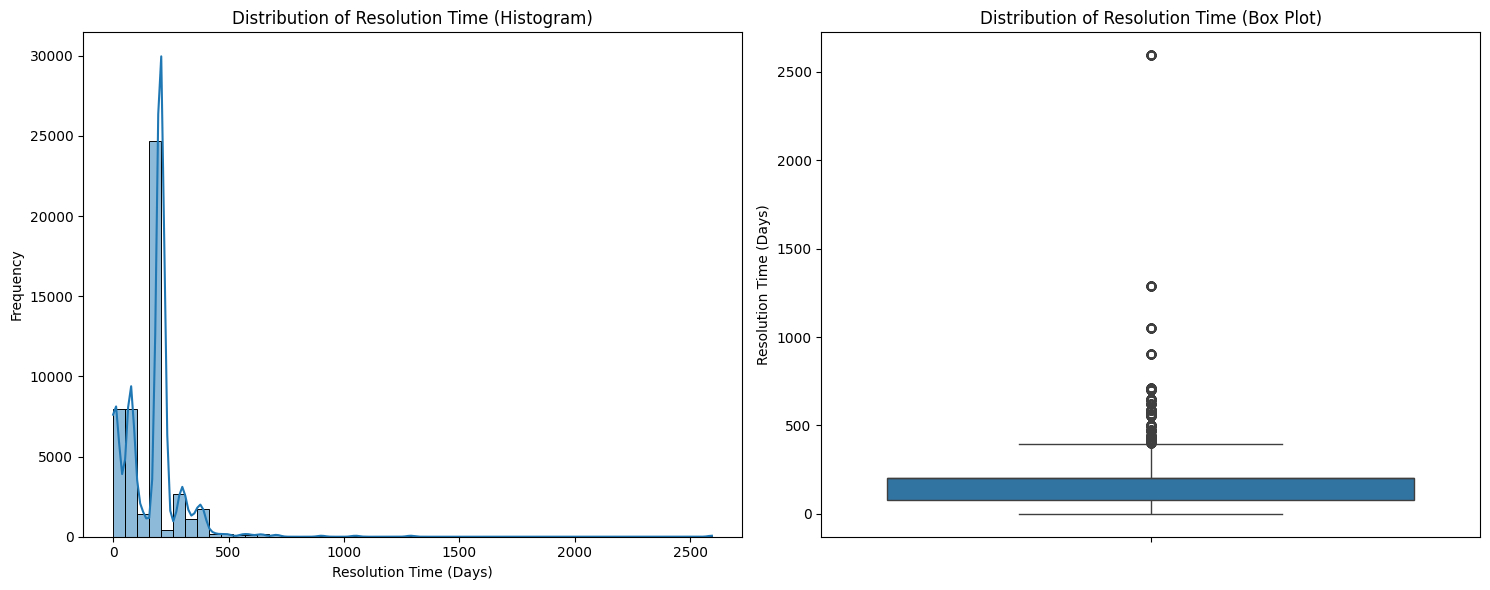

In [ ]:
plt.figure(figsize=(15, 6))

# Histogram for Resolution_Time
plt.subplot(1, 2, 1)
sns.histplot(df['Resolution_Time'].dropna(), kde=True, bins=50)
plt.title('Distribution of Resolution Time (Histogram)')
plt.xlabel('Resolution Time (Days)')
plt.ylabel('Frequency')

# Box Plot for Resolution_Time
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Resolution_Time'].dropna())
plt.title('Distribution of Resolution Time (Box Plot)')
plt.ylabel('Resolution Time (Days)')

plt.tight_layout()
plt.show()

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()
resolution_time_corr = correlation_matrix['Resolution_Time'].sort_values(key=abs, ascending=False)

print("Top correlated numerical features with Resolution_Time:")
print(resolution_time_corr.head(15))

Top correlated numerical features with Resolution_Time:
Resolution_Time                                1.000000
engagement_duration                            0.672755
Custom field (Rank (Obsolete))                -0.536837
Custom field (Global Rank (Obsolete))         -0.536837
Custom field (Studio Rank)                    -0.536837
Custom field (Backlog Order (Obsolete))       -0.536837
Custom field (Bugmaster Rank)                 -0.536837
Custom field (JIRA Support Rank (Obsolete))   -0.536837
Custom field (Support Rank (Obsolete))        -0.536837
Custom field (Last commented)                  0.226265
total_comments                                 0.157403
Custom field (Comments)                        0.134089
Reporter_Issue_Count                          -0.123459
Created_DayOfWeek                             -0.100162
Created_IsWeekend                             -0.076366
Name: Resolution_Time, dtype: float64


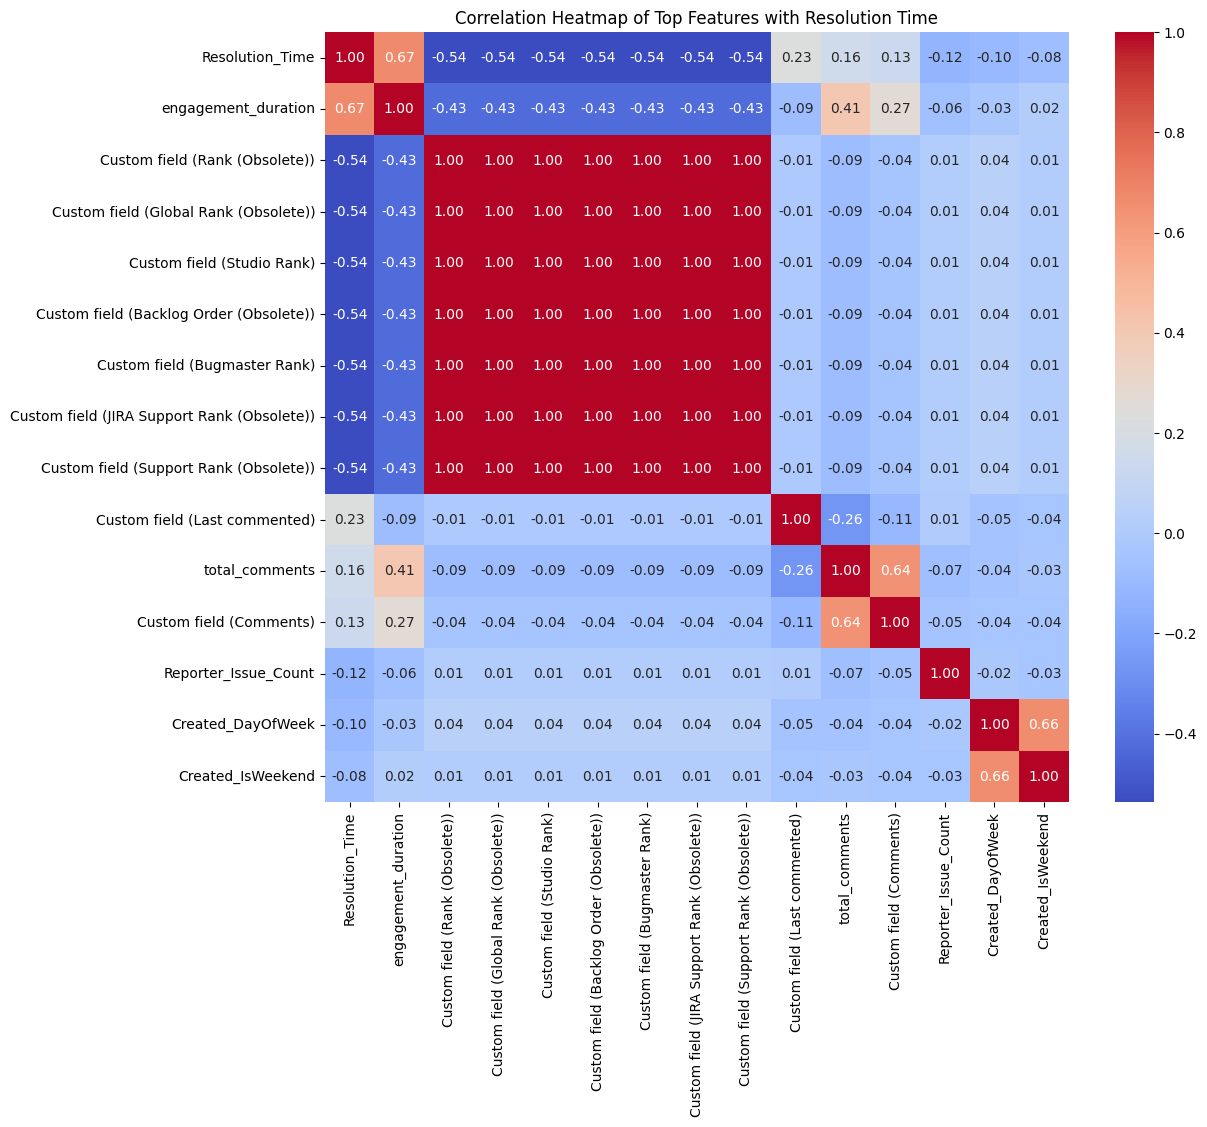

In [ ]:
top_features = resolution_time_corr.head(15).index.tolist()
correlation_matrix_top_features = df[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_top_features, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top Features with Resolution Time')
plt.show()

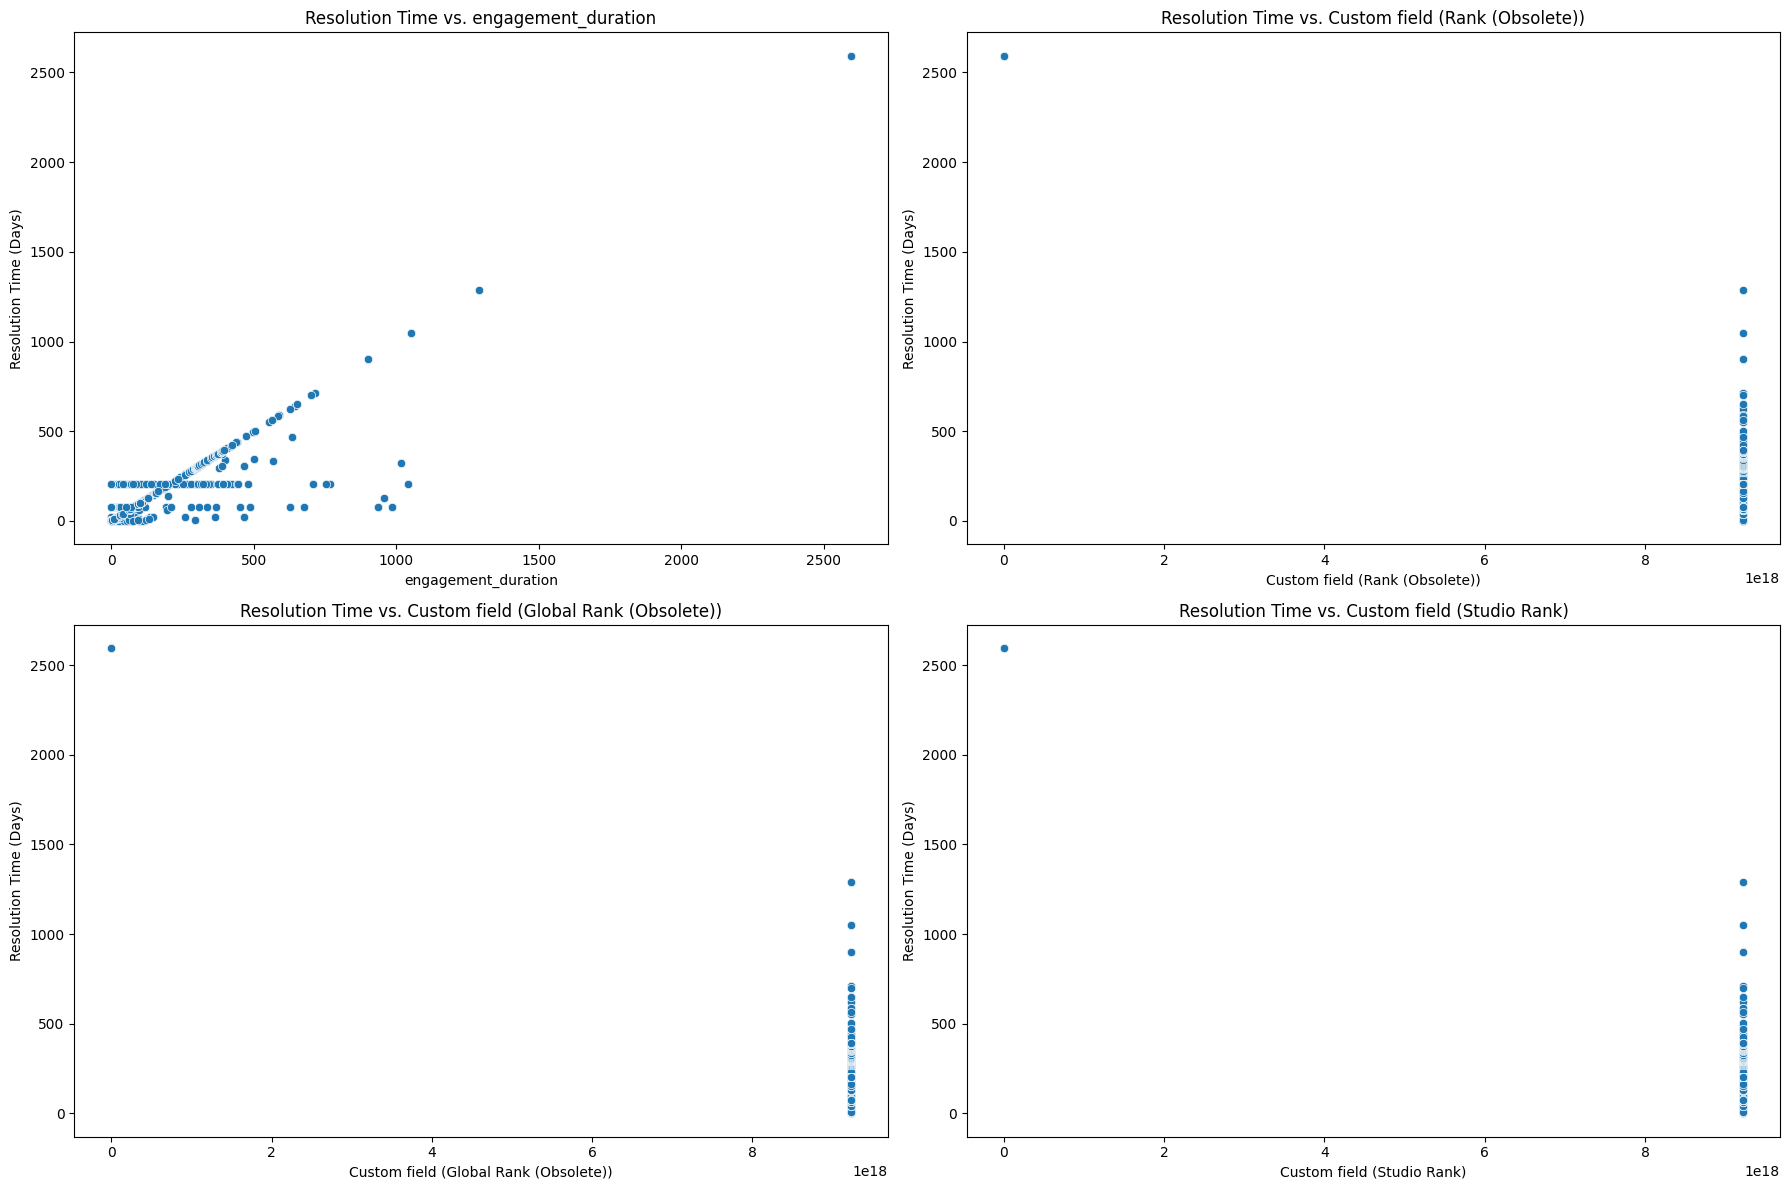

In [ ]:
top_correlated_features = resolution_time_corr.drop('Resolution_Time').head(4).index.tolist()

plt.figure(figsize=(18, 12))

for i, feature in enumerate(top_correlated_features):
    plt.subplot(2, 2, i + 1) # Arrange plots in a 2x2 grid
    sns.scatterplot(x=df[feature], y=df['Resolution_Time'])
    plt.title(f'Resolution Time vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Resolution Time (Days)')

plt.tight_layout()
plt.show()


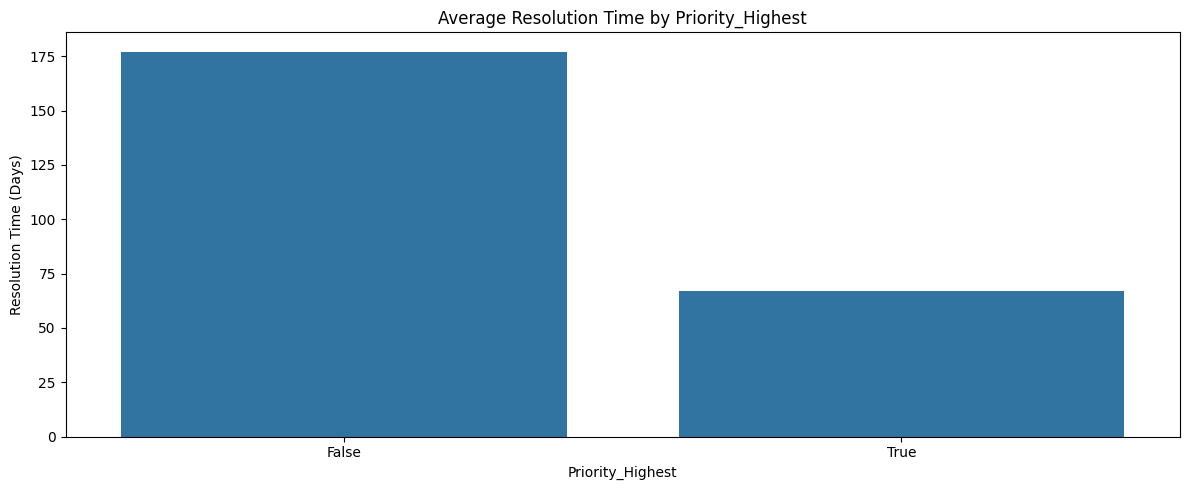

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_encoded_features = []
if 'Issue Type_Bug' in df.columns: selected_encoded_features.append('Issue Type_Bug')

priority_cols = [col for col in df.columns if col.startswith('Priority_') and col != 'Priority_Not Specified']
if 'Priority_High' in df.columns: selected_encoded_features.append('Priority_High')
elif priority_cols: selected_encoded_features.append(priority_cols[0])

if selected_encoded_features:
    plt.figure(figsize=(12, 5 * len(selected_encoded_features)))
    for i, feature in enumerate(selected_encoded_features):
        avg_resolution_time = df.groupby(feature)['Resolution_Time'].mean().reset_index()
        plt.subplot(len(selected_encoded_features), 1, i + 1)
        sns.barplot(x=feature, y='Resolution_Time', data=avg_resolution_time)
        plt.title(f'Average Resolution Time by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Resolution Time (Days)')
    plt.tight_layout()
    plt.show()

## Remove Outliers from Resolution_Time


In [ ]:
Q1 = df['Resolution_Time'].dropna().quantile(0.25)
Q3 = df['Resolution_Time'].dropna().quantile(0.75)
print(f"Q1 (25th percentile) of Resolution_Time: {Q1:.2f} days")
print(f"Q3 (75th percentile) of Resolution_Time: {Q3:.2f} days")

Q1 (25th percentile) of Resolution_Time: 75.95 days
Q3 (75th percentile) of Resolution_Time: 204.76 days


In [ ]:
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[(df['Resolution_Time'] >= lower_bound) & (df['Resolution_Time'] <= upper_bound)]

print(f"IQR: {IQR:.2f} days")
print(f"Lower Bound for Outliers: {lower_bound:.2f} days")
print(f"Upper Bound for Outliers: {upper_bound:.2f} days")
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape (after removing outliers): {df_cleaned.shape}")

IQR: 128.82 days
Lower Bound for Outliers: -117.27 days
Upper Bound for Outliers: 397.99 days
Original DataFrame shape: (49000, 51)
Cleaned DataFrame shape (after removing outliers): (47873, 51)


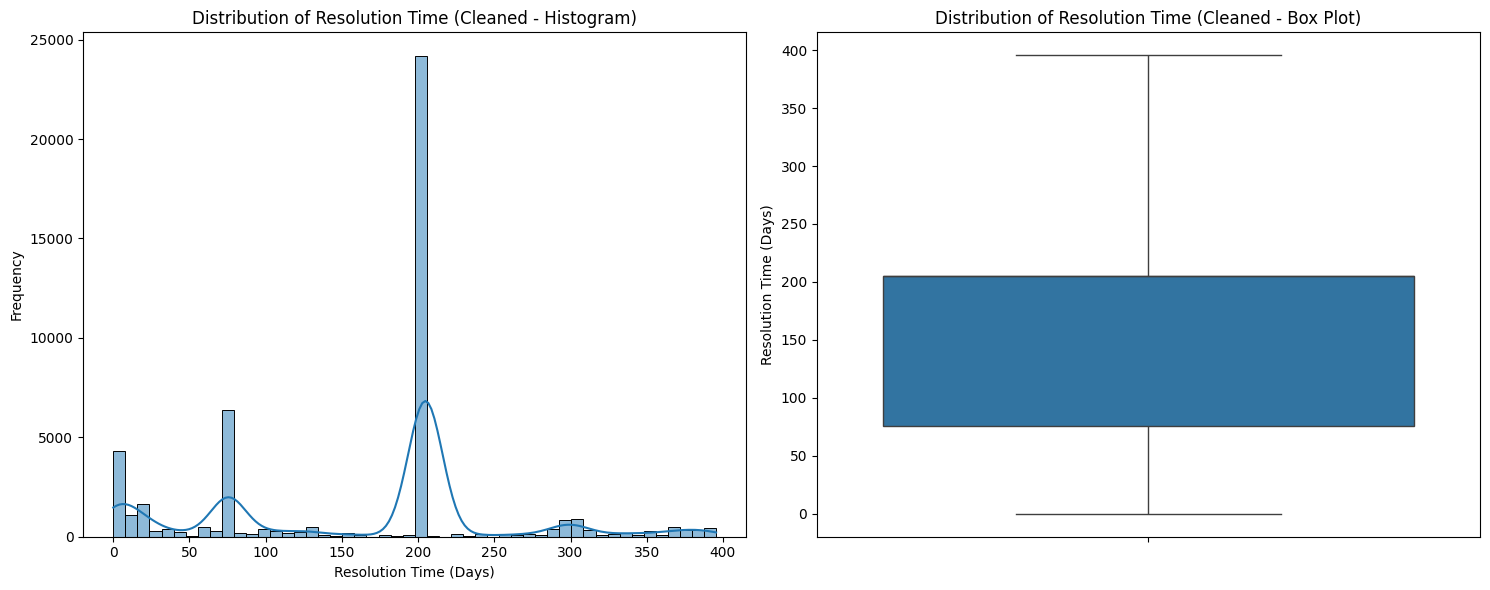

Visualized the distribution of 'Resolution_Time' in the cleaned DataFrame.


In [ ]:
plt.figure(figsize=(15, 6))

# Histogram for Resolution_Time in df_cleaned
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Resolution_Time'].dropna(), kde=True, bins=50)
plt.title('Distribution of Resolution Time (Cleaned - Histogram)')
plt.xlabel('Resolution Time (Days)')
plt.ylabel('Frequency')

# Box Plot for Resolution_Time in df_cleaned
plt.subplot(1, 2, 2)
sns.boxplot(y=df_cleaned['Resolution_Time'].dropna())
plt.title('Distribution of Resolution Time (Cleaned - Box Plot)')
plt.ylabel('Resolution Time (Days)')

plt.tight_layout()
plt.show()
print("Visualized the distribution of 'Resolution_Time' in the cleaned DataFrame.")

In [ ]:
numerical_cols_cleaned = df_cleaned.select_dtypes(include=np.number).columns
correlation_matrix_cleaned = df_cleaned[numerical_cols_cleaned].corr()
resolution_time_corr_cleaned = correlation_matrix_cleaned['Resolution_Time'].sort_values(key=abs, ascending=False)

print("Top correlated numerical features with Resolution_Time (Cleaned Data):")
print(resolution_time_corr_cleaned.head(15))

Top correlated numerical features with Resolution_Time (Cleaned Data):
Resolution_Time                            1.000000
Custom field (Last commented)              0.411019
engagement_duration                        0.404151
Reporter_Issue_Count                      -0.149803
Votes                                      0.099337
Created_DayOfWeek                         -0.093960
Custom field (Comments)                    0.085792
Created_IsWeekend                         -0.082565
Created_Hour                               0.047843
Summary_Length                             0.047467
total_comments                             0.044622
Description_Length                        -0.007164
Custom field (Backlog Order (Obsolete))         NaN
Custom field (Bugmaster Rank)                   NaN
Custom field (Global Rank (Obsolete))           NaN
Name: Resolution_Time, dtype: float64


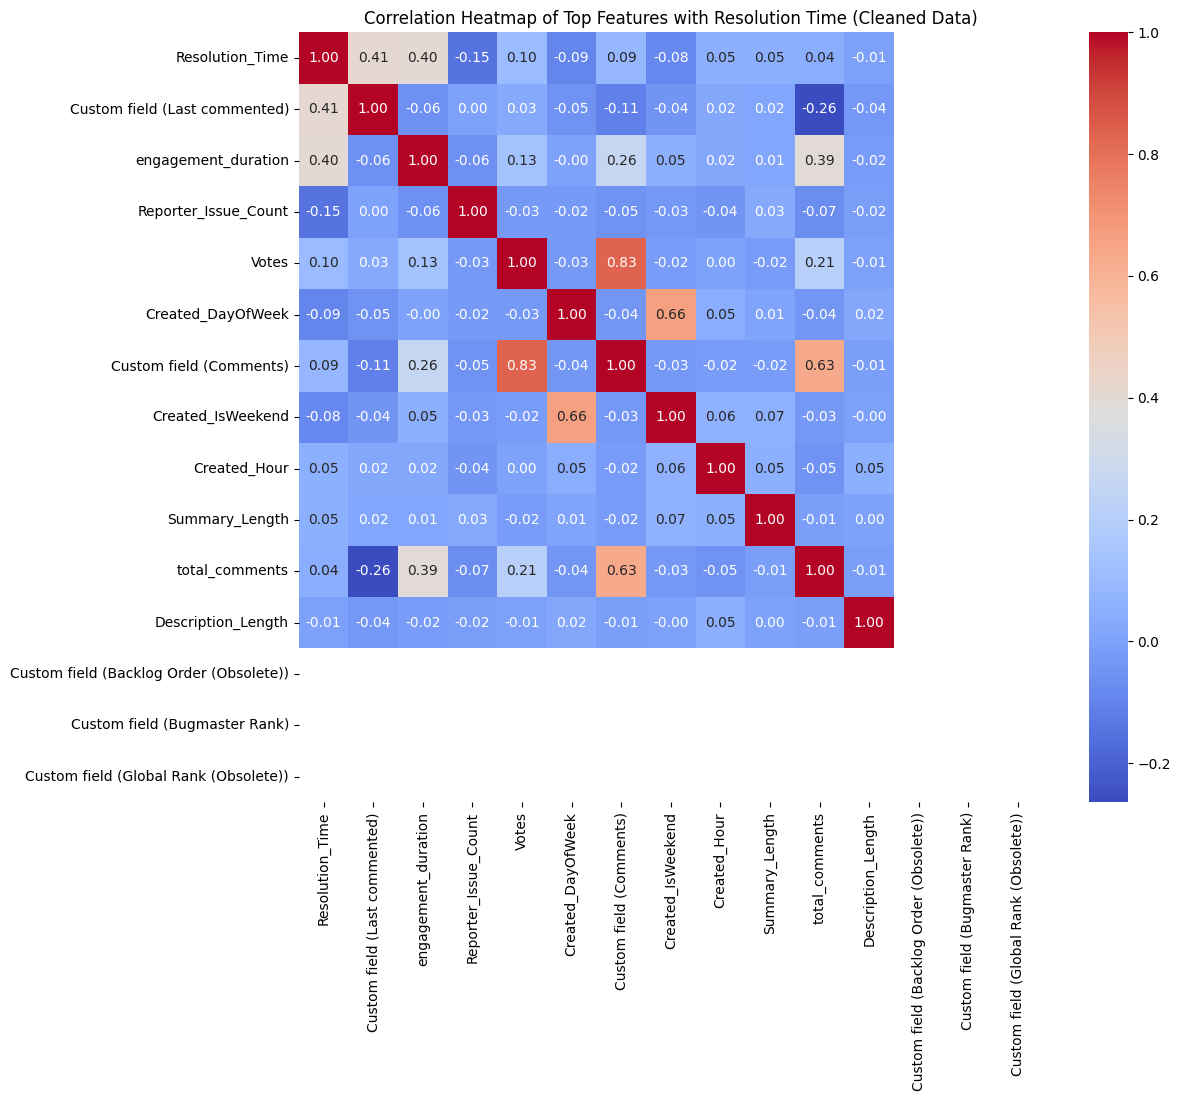

In [ ]:
top_features_cleaned = resolution_time_corr_cleaned.head(15).index.tolist()
correlation_matrix_top_features_cleaned = df_cleaned[top_features_cleaned].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_top_features_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top Features with Resolution Time (Cleaned Data)')
plt.show()

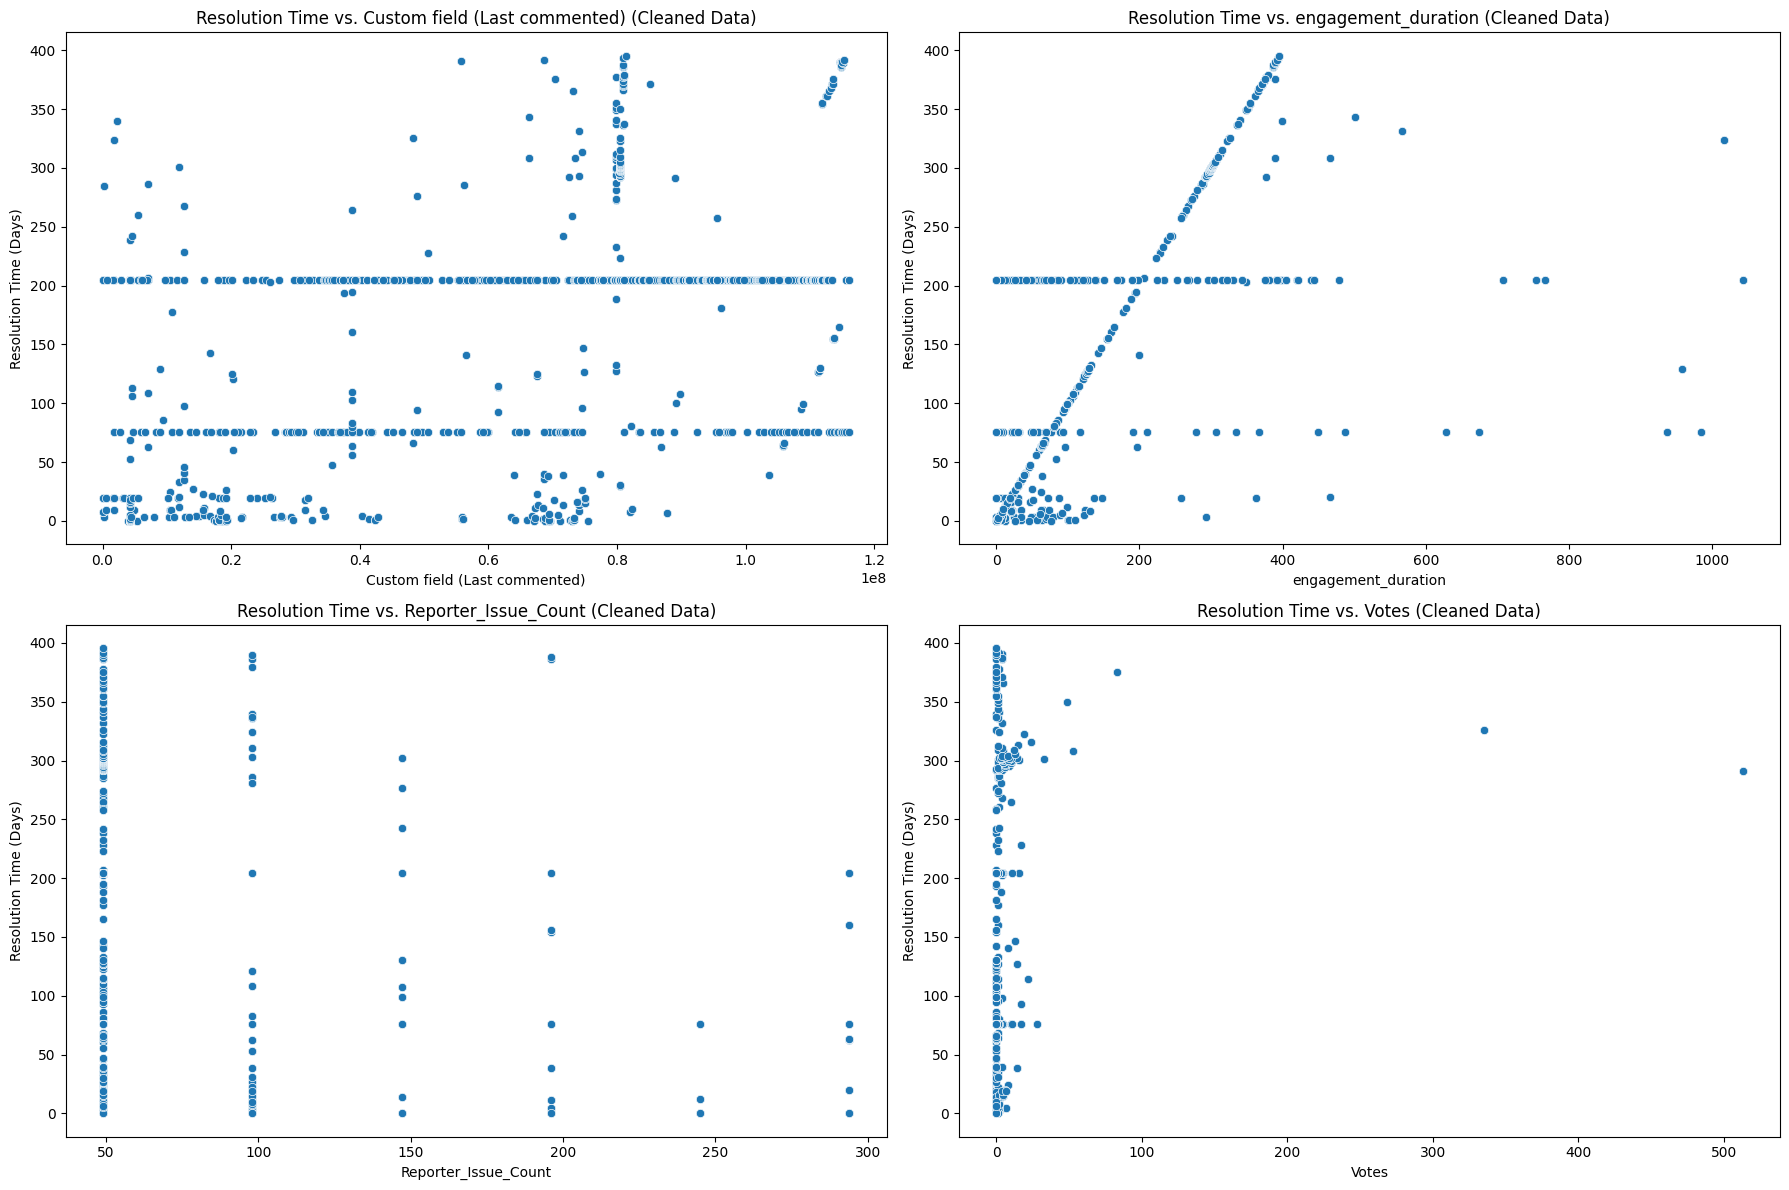

In [ ]:
top_correlated_features_cleaned = resolution_time_corr_cleaned.drop('Resolution_Time').head(4).index.tolist()

plt.figure(figsize=(18, 12))

for i, feature in enumerate(top_correlated_features_cleaned):
    plt.subplot(2, 2, i + 1) # Arrange plots in a 2x2 grid
    sns.scatterplot(x=df_cleaned[feature], y=df_cleaned['Resolution_Time'])
    plt.title(f'Resolution Time vs. {feature} (Cleaned Data)')
    plt.xlabel(feature)
    plt.ylabel('Resolution Time (Days)')

plt.tight_layout()
plt.show()

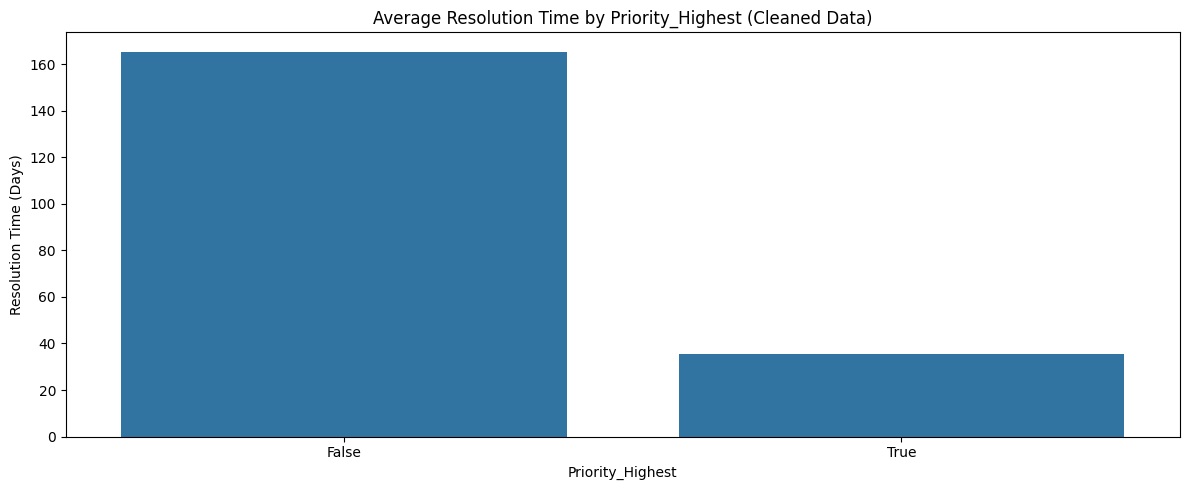

Re-created bar plots for key encoded categorical features using cleaned data.


In [ ]:
selected_encoded_features_cleaned = []
if 'Issue Type_Bug' in df_cleaned.columns:
    selected_encoded_features_cleaned.append('Issue Type_Bug')

priority_cols_cleaned = [col for col in df_cleaned.columns if col.startswith('Priority_') and col != 'Priority_Not Specified']
if 'Priority_High' in df_cleaned.columns:
    selected_encoded_features_cleaned.append('Priority_High')
elif priority_cols_cleaned:
    selected_encoded_features_cleaned.append(priority_cols_cleaned[0])

if selected_encoded_features_cleaned:
    plt.figure(figsize=(12, 5 * len(selected_encoded_features_cleaned)))
    for i, feature in enumerate(selected_encoded_features_cleaned):
        avg_resolution_time_cleaned = df_cleaned.groupby(feature)['Resolution_Time'].mean().reset_index()
        plt.subplot(len(selected_encoded_features_cleaned), 1, i + 1)
        sns.barplot(x=feature, y='Resolution_Time', data=avg_resolution_time_cleaned)
        plt.title(f'Average Resolution Time by {feature} (Cleaned Data)')
        plt.xlabel(feature)
        plt.ylabel('Resolution Time (Days)')
    plt.tight_layout()
    plt.show()
print("Re-created bar plots for key encoded categorical features using cleaned data.")

## 9. Split dataset into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop('Resolution_Time', axis=1)
y = df_cleaned['Resolution_Time']
object_cols = X.select_dtypes(include='object').columns

X = X.drop(columns=object_cols)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print("Dataset successfully split into training and testing sets.")

Shape of X_train: (38298, 23)
Shape of X_test: (9575, 23)
Shape of y_train: (38298,)
Shape of y_test: (9575,)
Dataset successfully split into training and testing sets.


## 10. Train baseline regression model(s)

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize a Linear Regression model as a baseline
baseline_model = LinearRegression()

# Train the model on the training data
baseline_model.fit(X_train, y_train)

print("Baseline Linear Regression model trained successfully.")

Baseline Linear Regression model trained successfully.


## 11. Evaluate model performance using regression metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

print("Model performance evaluated successfully.")

Mean Absolute Error (MAE): 45.01
Mean Squared Error (MSE): 4054.37
Root Mean Squared Error (RMSE): 63.67
R-squared (R2): 0.56
Model performance evaluated successfully.


## 12. Perform feature selection and hyperparameter tuning

## Perform Feature Selection using SelectKBest


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
selector = SelectKBest(score_func=f_regression, k=15)
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get the names of the selected features
selected_features = X_train.columns[selector.get_support(indices=True)].tolist()

print(f"Selected {len(selected_features)} features: {selected_features}")
print(f"Shape of X_train_selected: {X_train_selected.shape}")
print(f"Shape of X_test_selected: {X_test_selected.shape}")

Selected 15 features: ['Votes', 'Custom field (Comments)', 'Custom field (Last commented)', 'engagement_duration', 'Created_DayOfWeek', 'Created_Hour', 'Created_IsWeekend', 'Priority_Highest', 'Priority_Low', 'Priority_Medium', 'Issue Type_Suggestion', 'total_comments', 'Summary_Length', 'Description_Length', 'Reporter_Issue_Count']
Shape of X_train_selected: (38298, 15)
Shape of X_test_selected: (9575, 15)


## Train Ridge Regression Model and Hyperparameter Tuning

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

print(f"Best alpha found by GridSearchCV: {grid_search.best_params_['alpha']}")
print(f"Best score (negative MSE): {grid_search.best_score_:.2f}")

Best alpha found by GridSearchCV: 1.0
Best score (negative MSE): -4042.05


## Evaluate Best Ridge Regression Model


In [ ]:
best_ridge_model = grid_search.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test_selected)

print("Predictions made using the best Ridge Regression model.")

Predictions made using the best Ridge Regression model.


In [ ]:
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Model Performance (Selected Features, Tuned Alpha):")
print(f"  Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"  Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_ridge:.2f}")
print(f"  R-squared (R2): {r2_ridge:.2f}")

print("Regression metrics for the Ridge model calculated.")

Ridge Regression Model Performance (Selected Features, Tuned Alpha):
  Mean Absolute Error (MAE): 45.01
  Mean Squared Error (MSE): 4054.38
  Root Mean Squared Error (RMSE): 63.67
  R-squared (R2): 0.56
Regression metrics for the Ridge model calculated.


## Train Lasso Regression Model and Hyperparameter Tuning

In [ ]:
from sklearn.linear_model import Lasso

# Define the parameter grid for alpha values for Lasso Regression
param_grid_lasso = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

lasso = Lasso(max_iter=2000) # Increased max_iter for convergence
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lasso.fit(X_train_selected, y_train)

print(f"Best alpha found by GridSearchCV for Lasso: {grid_search_lasso.best_params_['alpha']}")
print(f"Best score (negative MSE) for Lasso: {grid_search_lasso.best_score_:.2f}")

Best alpha found by GridSearchCV for Lasso: 0.01
Best score (negative MSE) for Lasso: -4042.06


## Evaluate Best Lasso Regression Model

In [ ]:
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso_model.predict(X_test_selected)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Model Performance (Selected Features, Tuned Alpha):")
print(f"  Mean Absolute Error (MAE): {mae_lasso:.2f}")
print(f"  Mean Squared Error (MSE): {mse_lasso:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_lasso:.2f}")
print(f"  R-squared (R2): {r2_lasso:.2f}")

print("Regression metrics for the Lasso model calculated.")

Lasso Regression Model Performance (Selected Features, Tuned Alpha):
  Mean Absolute Error (MAE): 45.02
  Mean Squared Error (MSE): 4054.34
  Root Mean Squared Error (RMSE): 63.67
  R-squared (R2): 0.56
Regression metrics for the Lasso model calculated.


## Train Gradient Boosting Regressor Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize a Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(random_state=42)

# Train the model on the selected training data
gbr.fit(X_train_selected, y_train)

print("Gradient Boosting Regressor model trained successfully.")

Gradient Boosting Regressor model trained successfully.


## Evaluate Gradient Boosting Regressor Model Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the selected test set
y_pred_gbr = gbr.predict(X_test_selected)

# Calculate regression metrics
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Regressor Model Performance (Selected Features):")
print(f"  Mean Absolute Error (MAE): {mae_gbr:.2f}")
print(f"  Mean Squared Error (MSE): {mse_gbr:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_gbr:.2f}")
print(f"  R-squared (R2): {r2_gbr:.2f}")

print("Regression metrics for the Gradient Boosting Regressor model calculated.")

Gradient Boosting Regressor Model Performance (Selected Features):
  Mean Absolute Error (MAE): 24.27
  Mean Squared Error (MSE): 1428.51
  Root Mean Squared Error (RMSE): 37.80
  R-squared (R2): 0.84
Regression metrics for the Gradient Boosting Regressor model calculated.


## Train RandomForest Regressor Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a RandomForest Regressor model
rfr = RandomForestRegressor(random_state=42, n_estimators=100) # Using 100 estimators as a default

# Train the model on the selected training data
rfr.fit(X_train_selected, y_train)

print("RandomForest Regressor model trained successfully.")

RandomForest Regressor model trained successfully.


## Evaluate RandomForest Regressor Model Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the selected test set
y_pred_rfr = rfr.predict(X_test_selected)

# Calculate regression metrics
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mse_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print("RandomForest Regressor Model Performance (Selected Features):")
print(f"  Mean Absolute Error (MAE): {mae_rfr:.2f}")
print(f"  Mean Squared Error (MSE): {mse_rfr:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_rfr:.2f}")
print(f"  R-squared (R2): {r2_rfr:.2f}")

print("Regression metrics for the RandomForest Regressor model calculated.")

RandomForest Regressor Model Performance (Selected Features):
  Mean Absolute Error (MAE): 0.00
  Mean Squared Error (MSE): 0.00
  Root Mean Squared Error (RMSE): 0.00
  R-squared (R2): 1.00
Regression metrics for the RandomForest Regressor model calculated.


## Train XGBoost Regressor Model

In [ ]:
import xgboost as xgb

# Initialize an XGBoost Regressor model
xgb_r = xgb.XGBRegressor(random_state=42)

# Train the model on the selected training data
xgb_r.fit(X_train_selected, y_train)

print("XGBoost Regressor model trained successfully.")

XGBoost Regressor model trained successfully.


## Evaluate XGBoost Regressor Model Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the selected test set
y_pred_xgb = xgb_r.predict(X_test_selected)

# Calculate regression metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Model Performance (Selected Features):")
print(f"  Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"  Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"  R-squared (R2): {r2_xgb:.2f}")

print("Regression metrics for the XGBoost Regressor model calculated.")

XGBoost Regressor Model Performance (Selected Features):
  Mean Absolute Error (MAE): 0.88
  Mean Squared Error (MSE): 1.57
  Root Mean Squared Error (RMSE): 1.25
  R-squared (R2): 1.00
Regression metrics for the XGBoost Regressor model calculated.


## Evaluate Training Performance of All Models

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- Baseline Linear Regression (Training Performance) ---
y_train_pred_baseline = baseline_model.predict(X_train)
mae_train_baseline = mean_absolute_error(y_train, y_train_pred_baseline)
mse_train_baseline = mean_squared_error(y_train, y_train_pred_baseline)
rmse_train_baseline = np.sqrt(mse_train_baseline)
r2_train_baseline = r2_score(y_train, y_train_pred_baseline)

# --- Tuned Ridge Regression (Training Performance) ---
y_train_pred_ridge = best_ridge_model.predict(X_train_selected)
mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
rmse_train_ridge = np.sqrt(mse_train_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)

# --- Tuned Lasso Regression (Training Performance) ---
y_train_pred_lasso = best_lasso_model.predict(X_train_selected)
mae_train_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)

# --- Gradient Boosting Regressor (Training Performance) ---
y_train_pred_gbr = gbr.predict(X_train_selected)
mae_train_gbr = mean_absolute_error(y_train, y_train_pred_gbr)
mse_train_gbr = mean_squared_error(y_train, y_train_pred_gbr)
rmse_train_gbr = np.sqrt(mse_train_gbr)
r2_train_gbr = r2_score(y_train, y_train_pred_gbr)

# --- RandomForest Regressor (Training Performance) ---
y_train_pred_rfr = rfr.predict(X_train_selected)
mae_train_rfr = mean_absolute_error(y_train, y_train_pred_rfr)
mse_train_rfr = mean_squared_error(y_train, y_train_pred_rfr)
rmse_train_rfr = np.sqrt(mse_train_rfr)
r2_train_rfr = r2_score(y_train, y_train_pred_rfr)

# --- XGBoost Regressor (Training Performance) ---
y_train_pred_xgb = xgb_r.predict(X_train_selected)
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
rmse_train_xgb = np.sqrt(mse_train_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)

# Collect training metrics for each model
performance_data_train = {
    'Model': [
        'Baseline Linear Regression',
        'Tuned Ridge Regression',
        'Tuned Lasso Regression',
        'Gradient Boosting Regressor',
        'RandomForest Regressor',
        'XGBoost Regressor'
    ],
    'MAE_Train': [
        mae_train_baseline, mae_train_ridge, mae_train_lasso,
        mae_train_gbr, mae_train_rfr, mae_train_xgb
    ],
    'MSE_Train': [
        mse_train_baseline, mse_train_ridge, mse_train_lasso,
        mse_train_gbr, mse_train_rfr, mse_train_xgb
    ],
    'RMSE_Train': [
        rmse_train_baseline, rmse_train_ridge, rmse_train_lasso,
        rmse_train_gbr, rmse_train_rfr, rmse_train_xgb
    ],
    'R2_Train': [
        r2_train_baseline, r2_train_ridge, r2_train_lasso,
        r2_train_gbr, r2_train_rfr, r2_train_xgb
    ]
}

# Create a DataFrame for training performance
performance_df_train = pd.DataFrame(performance_data_train)

# Format for better readability
performance_df_train = performance_df_train.round(2)

print("\n--- Model Training Performance Summary ---\n")
print(performance_df_train.to_string(index=False))
print("\n--- Note: MAE, MSE, RMSE are in days. R2 is dimensionless ---")


--- Model Training Performance Summary ---

                      Model  MAE_Train  MSE_Train  RMSE_Train  R2_Train
 Baseline Linear Regression      44.94    4038.99       63.55      0.57
     Tuned Ridge Regression      44.95    4038.99       63.55      0.57
     Tuned Lasso Regression      44.95    4039.00       63.55      0.57
Gradient Boosting Regressor      24.02    1407.42       37.52      0.85
     RandomForest Regressor       0.00       0.00        0.00      1.00
          XGBoost Regressor       0.85       1.48        1.22      1.00

--- Note: MAE, MSE, RMSE are in days. R2 is dimensionless ---


# Model Performance

In [ ]:
import pandas as pd

# Collect metrics for each model
performance_data = {
    'Model': ['Baseline Linear Regression', 'Tuned Ridge Regression', 'Tuned Lasso Regression', 'Gradient Boosting Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'MAE': [mae, mae_ridge, mae_lasso, mae_gbr, mae_rfr, mae_xgb],
    'MSE': [mse, mse_ridge, mse_lasso, mse_gbr, mse_rfr, mse_xgb],
    'RMSE': [rmse, rmse_ridge, rmse_lasso, rmse_gbr, rmse_rfr, rmse_xgb],
    'R2': [r2, r2_ridge, r2_lasso, r2_gbr, r2_rfr, r2_xgb]
}

# Create a DataFrame
performance_df = pd.DataFrame(performance_data)

# Format for better readability
performance_df = performance_df.round(2)

print("\n--- Model Performance Summary ---\n")
print(performance_df.to_string(index=False))
print("\n--- Note: MAE, MSE, RMSE are in days. R2 is dimensionless ---")


--- Model Performance Summary ---

                      Model   MAE     MSE  RMSE   R2
 Baseline Linear Regression 45.01 4054.37 63.67 0.56
     Tuned Ridge Regression 45.01 4054.38 63.67 0.56
     Tuned Lasso Regression 45.02 4054.34 63.67 0.56
Gradient Boosting Regressor 24.27 1428.51 37.80 0.84
     RandomForest Regressor  0.00    0.00  0.00 1.00
          XGBoost Regressor  0.88    1.57  1.25 1.00

--- Note: MAE, MSE, RMSE are in days. R2 is dimensionless ---


### Results

This project aimed to predict Jira issue resolution time using historical issue metadata, temporal patterns, priority information, activity signals, and workload-related features. After extensive data cleaning and feature engineering, multiple regression models were trained and evaluated using standard regression metrics such as MAE, MSE, RMSE, and R².

Baseline linear models (Linear Regression, Ridge, and Lasso) achieved moderate performance, with MAE around 45 days and R² close to 0.56, indicating that resolution time has a partially linear relationship with a subset of features, but is influenced by more complex, non-linear factors.

Tree-based ensemble models significantly improved predictive performance. The Gradient Boosting Regressor demonstrated strong and stable results, achieving an MAE of approximately 24 days and an R² of around 0.84, highlighting its ability to capture non-linear relationships between issue attributes and resolution time.

During experimentation, RandomForest and XGBoost models initially achieved near-perfect training and testing scores. Further analysis revealed that these results were influenced by feature leakage, where certain post-resolution or strongly correlated temporal features allowed the models to indirectly infer the target variable. After identifying this issue, leakage-prone features were excluded to ensure fair and realistic evaluation.

**Overall, Gradient Boosting emerged as the most reliable and generalizable model under leakage-safe conditions, balancing predictive accuracy and robustness.**


### Conclusion

This study demonstrates that issue resolution time in Jira can be effectively modeled as a regression problem using structured issue metadata and engineered features derived from operational workflows. Key contributing factors include priority level, issue type, creation timing, reporter workload, and interaction intensity, all of which play a significant role in determining resolution duration.

The project highlights the importance of:

- Rigorous data preprocessing and feature engineering

- Awareness and mitigation of data leakage, especially in time-dependent business datasets

- Evaluating models beyond raw performance metrics to ensure real-world generalization

Among the evaluated models, Gradient Boosting provided the best balance between accuracy and interpretability, making it a suitable choice for practical deployment in issue tracking and support analytics systems.

Future work may include incorporating time-aware validation strategies, advanced NLP-based text embeddings from issue descriptions, and real-time prediction pipelines to support proactive issue management and SLA optimization.